In [44]:
import shutil
import os
import cv2 as cv
import pywt
import numpy as np



from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import seaborn as sns

In [45]:
members = ["Aditya","Rahul","Sangeeta","Sunil"]

In [46]:
cropped_image_dirs = ['FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya','FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Rahul','FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Sangeeta','FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Sunil']

In [47]:
member_file_dict = {}
for img_dirs in cropped_image_dirs:
    member_name = img_dirs.split("/")[-1]
    file_list = []
    for image_files in os.scandir(img_dirs):
        file_list.append(image_files.path)
    member_file_dict[member_name] = file_list
print(member_file_dict)

{'Aditya': ['FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya10.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya11.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya12.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya2.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya28.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya3.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya31.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya32.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya33.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya34.png', 'FACE RECOGNITION AND IDENTIFICATION/model/Family Dataset/cropped/Aditya\\Aditya37.png', 'FACE RECOG

In [48]:
member_names = {}
count = 0
for member_name in member_file_dict.keys():
    member_names[member_name] = count
    count = count+1
print(member_names)

{'Aditya': 0, 'Rahul': 1, 'Sangeeta': 2, 'Sunil': 3}


In [49]:
import pywt
def wavelet_transform(img,mode="haar",level=1):
    img_array = img
    img_array = cv.cvtColor(img_array,cv.COLOR_BGR2GRAY)
    img_array = np.float32(img_array)
    img_array /= 255;
    coeffs=pywt.wavedec2(img_array, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [50]:
X = []
y = []
for member,training_files in member_file_dict.items():
    for training_image in training_files:
        img = cv.imread(training_image)
        scalled_image = cv.resize(img,(32,32))
        image_wav_transform = wavelet_transform(scalled_image,'db1',5)
        transformed_scalled = cv.resize(image_wav_transform,(32,32))
        image_vertically_stacked = np.vstack((scalled_image.reshape(32*32*3,1),transformed_scalled.reshape(32*32,1)))
        X.append(image_vertically_stacked)
        y.append(member_names[member]) 

In [51]:
print(X[0])

[[ 52]
 [ 76]
 [156]
 ...
 [189]
 [193]
 [192]]


In [52]:
len(X),len(y)

(66, 66)

In [53]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(66, 4096)

In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [55]:
X_train.shape,X_test.shape

((49, 4096), (17, 4096))

In [56]:
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel = 'linear', C=10))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.9411764705882353

In [57]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       0.86      1.00      0.92         6

    accuracy                           0.94        17
   macro avg       0.96      0.95      0.95        17
weighted avg       0.95      0.94      0.94        17



In [61]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [67]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear','poly','sigmoid']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [68]:

scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.815556,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.611111,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.797778,{'logisticregression__C': 1}


In [69]:
best_estimators['svm'].score(X_test,y_test)

0.9411764705882353

In [71]:
best_estimators['random_forest'].score(X_test,y_test)

0.6470588235294118

In [72]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.9411764705882353

In [75]:
best_clf = best_estimators['svm']

In [76]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[3, 0, 0, 0],
       [0, 3, 0, 0],
       [0, 0, 4, 1],
       [0, 0, 0, 6]], dtype=int64)

Text(69.0, 0.5, 'Truth')

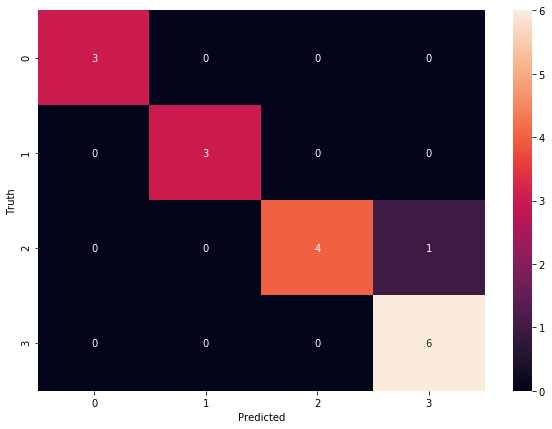

In [78]:
import seaborn as sn
from matplotlib import pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [80]:
import pickle
with open("Face_recognition_model.pickle","wb") as f:
    pickle.dump(best_clf,f)

In [83]:
import json
with open("member_numbers.json","w") as f:
    f.write(json.dumps(member_names))